# Classifieur KNN
Le classifieur KNN est assez simple et possède peu d'hyperparamètres, il sera donc facile à optimiser. On s'attend aussi à un bon résultat parce que les caractéristiques extraites devraient être assez représentatives des différentes espèces de feuilles.

In [15]:
import DataManagement as DM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

dataset = DM.Dataset('data/train.csv')
dataset.split_data(test_size=0.3, seed=0, stratified=True)
dataset.info()

(693, 192) (297, 192)
##### Informations #####
  - Nb classes   : 99 ( Dim : 195 )
  - Nb samples   : 990
     - Training  : 693 ( 70.0 % )
     - Test      : 297 ( 30.0 % )
########################


Puisque qu'on a beaucoup de classe et très peu de données par classe, on a séparé notre ensemble de données de façon à avoir autant de données dans chaque classe.

## Entrainement

Pour notre classifieur KNN, on utilise 3 hyperparamètres :
- Le nombre de voisins
- La pondération associée à chaque voisin : uniforme (sans pondération) ou selon la distance
- La métrique de distance

L'hyperparamètre le plus important est évidemment le nombre de voisin. Cependant, ce sera intéressant de voir si les autres hyperparamètres auront un impact significatif sur les performances du modèle.

### Recherche des hyperparamètres

On utilise une validation croisée à 5 plis. On utilise un nombre de plis assez petit parce qu'on a très peu de données par classe (seulement 7) et on veut éviter d'avoir des plis qui n'ont pas de données pour certaines classes.

In [22]:
hyperparameters = {
    'n_neighbors': range(1,10),
    'weights': ['distance', 'uniform'],
    'metric': ['euclidean', 'manhattan', 'cosine']   
}

grid, results = DM.train_model(KNeighborsClassifier(), hyperparameters, dataset)
print('Best:', grid.best_params_, 'with score {:.3}'.format(grid.best_score_))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'} with score 0.932


### Analyse de l'entrainement

Le nombre de voisin optimal est 4, ce qui veut dire qu'on se base sur très peu de points pour déterminer l'espèce d'une feuille. On peut regarder les scores de tous les modèles à 1 voisin pour voir l'impact des autres hyperparamètres.

In [17]:
results[results.param_n_neighbors == grid.best_params_['n_neighbors']]

,param_n_neighbors,param_weights,param_metric,mean_test_score,rank_test_score
6,4,distance,euclidean,0.855698,30
7,4,uniform,euclidean,0.818215,43
24,4,distance,manhattan,0.932166,1
25,4,uniform,manhattan,0.904775,12
42,4,distance,cosine,0.880242,22
43,4,uniform,cosine,0.836920,37


Les distances euclidiennes et cosinus sont assez similaire, mais la distance de manhattan est significativement différente et toujours supérieure.

On remarque aussi que pondérer les voisins selon la distance donne toujours un meilleur résultat, ce qui est assez logique; plus un voisin est loin, moins il a de chance d'appartenir à la même classe.

On peut tracer un graphique du score en fonction des différentes valeurs d'hyperparamètres pour réellement voir l'impact de leur variation sur le score.

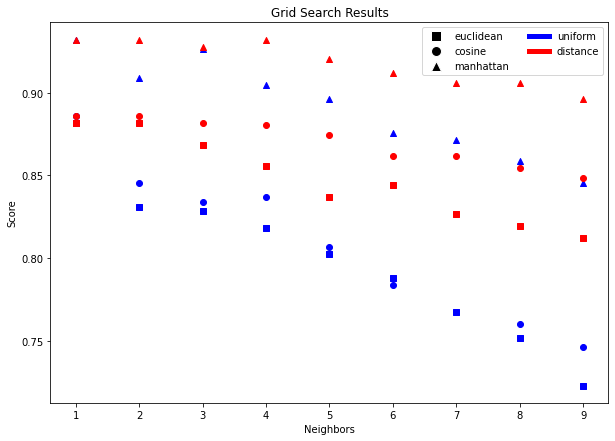

In [18]:
plt.figure(figsize=(10,7))

plt.scatter(results.query('param_metric == "euclidean" and param_weights == "uniform"')['param_n_neighbors'],
            results.query('param_metric == "euclidean" and param_weights == "uniform"')['mean_test_score'],
            marker='s', color='blue')
plt.scatter(results.query('param_metric == "cosine" and param_weights == "uniform"')['param_n_neighbors'],
            results.query('param_metric == "cosine" and param_weights == "uniform"')['mean_test_score'],
            marker='o', color='blue')
plt.scatter(results.query('param_metric == "manhattan" and param_weights == "uniform"')['param_n_neighbors'],
            results.query('param_metric == "manhattan" and param_weights == "uniform"')['mean_test_score'],
            marker='^', color='blue')
plt.scatter(results.query('param_metric == "euclidean" and param_weights == "distance"')['param_n_neighbors'],
            results.query('param_metric == "euclidean" and param_weights == "distance"')['mean_test_score'],
            marker='s', color='red')
plt.scatter(results.query('param_metric == "cosine" and param_weights == "distance"')['param_n_neighbors'],
            results.query('param_metric == "cosine" and param_weights == "distance"')['mean_test_score'],
            marker='o', color='red')
plt.scatter(results.query('param_metric == "manhattan" and param_weights == "distance"')['param_n_neighbors'],
            results.query('param_metric == "manhattan" and param_weights == "distance"')['mean_test_score'],
            marker='^', color='red')

plt.xlabel("Neighbors")
plt.ylabel("Score")
plt.title("Grid Search Results")

legend = [
    plt.Line2D([0], [0], marker='s', color='white', markerfacecolor='black', markersize=10, label='euclidean'), 
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='black', markersize=10, label='cosine'), 
    plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='black', markersize=10, label='manhattan'),
    plt.Line2D([0], [0], color='blue', linewidth=5, label='uniform'),
    plt.Line2D([0], [0], color='red', linewidth=5, label='distance')
    ]
plt.legend(handles=legend, ncols=2)

plt.show()

On remarque la distance de manhattan est toujours meilleure que les distances euclidienne et cosinus, et la pondération des voisins selon la distance est toujours meilleure que la pondération uniforme.

De plus, le score commence à décroitre lorsque le nombre de voisins est supérieur à 4. C'est assez logique; notre ensemble d'entrainement contient très peu de données par classe donc si on regarde beaucoup de voisins, la majorité d'entre eux appartiendront à des classes différentes. La décroissance est encore plus grande sans pondération, justement parce qu'on accorde trop d'importance aux voisins éloignés qui sont dans des classes différentes.

## Évaluation

On évalue le meilleur modèle entrainé à l'aide de notre ensemble de test. Pour l'évaluation, on regarde les métriques suivantes:
- La précision ("precision") : la proportion de données appartenant réellement à leur classe prédite
- Le rappel ("recall") : la proportion des données bien classées (la justesse des prédictions pour une classe)
- Le f1-score : la moyenne harmonique de la précision et du rappel

Comme nous sommes dans une situation de classification multi-classe, on calcule ces métriques individuellement pour chaque classe. On peut ensuite regarder la distribution des résultats pour évaluer notre modèle.

### Averages ###
   - precision : 96.397% ± 9.469%
   - recall    : 95.286% ± 13.477%
   - f1_score  : 95.005% ± 10.409%
################


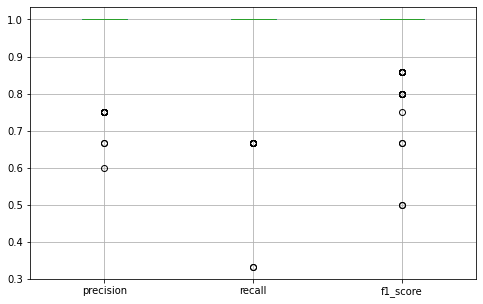

In [19]:
test_preds = grid.predict(dataset.x_test)
test_reports = DM.evaluate_predictions(dataset.t_test, test_preds, dataset.classes)

Comme nous avons 99 classes, il n'est pas pratique de regarder les résultats pour chacune d'entre elles. On regarde plutôt la moyenne de chaque métrique sur l'ensemble des classes. On peut alors voir que notre modèle fonctionne très bien. Il est à la fois précis et juste.

Comme on peut le voir dans le boxplot, les prédictions sont parfaites (métriques à 1.0) pour la grande majorité des classes. Il y a cependant des classes pour lesquelles le modèle a moins bien performé. Regardons de quelles classes il s'agit.

In [20]:
bad_classes = test_reports.query('precision < 1.0 or recall < 1.0')
print(bad_classes)
print('Sum:', len(bad_classes))

                           precision    recall  f1_score
Acer_Rubrum                 0.750000  1.000000  0.857143
Arundinaria_Simonii         1.000000  0.666667  0.800000
Crataegus_Monogyna          1.000000  0.333333  0.500000
Cytisus_Battandieri         1.000000  0.666667  0.800000
Eucalyptus_Glaucescens      0.750000  1.000000  0.857143
Eucalyptus_Neglecta         0.666667  0.666667  0.666667
Fagus_Sylvatica             1.000000  0.333333  0.500000
Ilex_Cornuta                1.000000  0.666667  0.800000
Lithocarpus_Cleistocarpus   0.750000  1.000000  0.857143
Morus_Nigra                 0.600000  1.000000  0.750000
Populus_Nigra               0.750000  1.000000  0.857143
Prunus_X_Shmittii           1.000000  0.666667  0.800000
Quercus_Canariensis         0.750000  1.000000  0.857143
Quercus_Cerris              0.750000  1.000000  0.857143
Quercus_Coccinea            0.750000  1.000000  0.857143
Quercus_Infectoria_sub      0.666667  0.666667  0.666667
Quercus_Kewensis            1.0

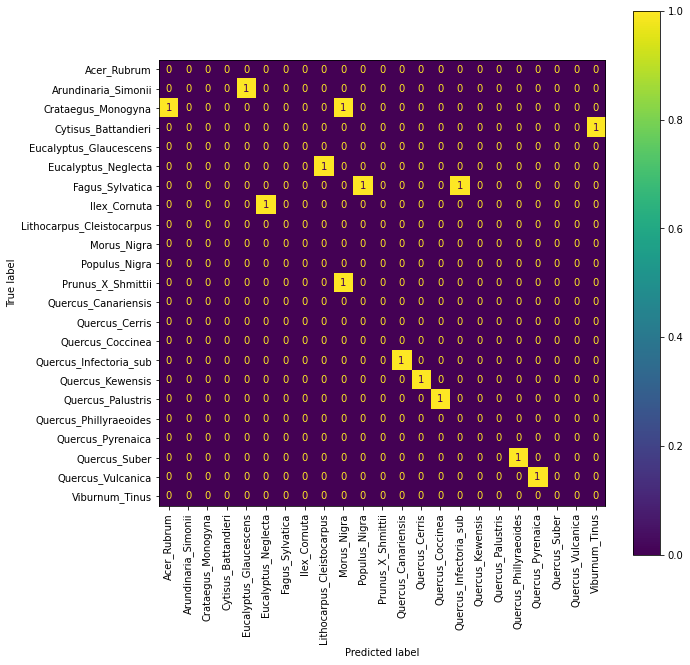

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

# Get all the wrong predictions
bad_preds = DM.extract_bad_predictions(dataset.t_test, test_preds, labels=dataset.classes, ids=dataset.id_test)

# Display them as a confusion matrix
display = ConfusionMatrixDisplay.from_predictions(bad_preds['True Class'], bad_preds['Predicted Class'], 
                                                  labels=bad_classes.index, xticks_rotation='vertical')
display.figure_.set_figwidth(10)
display.figure_.set_figheight(10)

plt.show()

Il ne semble pas se dégager de relation particulière parmis les mauvaises prédictions. Il s'agit donc probablement de données pour lesquelles les caractéristiques sont moins distinctes.

### Conclusion

Le classifieur KNN est optimal lorsqu'on utilise 4 voisins, la distance de manhattan et une pondération des voisins selon la distance. Avec ces hyperparamètres, le modèle performe très bien (> 95% pour chaque métrique d'évaluation) et ne semble donc ni sous-apprendre ni sur-apprendre.

Cependant, on doit rappeler que notre jeu de données contient beaucoup de classes (99) et assez peu de données par classes (seulement 10). Notre ensemble de test lui ne contenait que 3 données par classe, ce qui est très peu. Donc il est difficile de dire si les résultats obtenus correspondent aux vraies performances du modèle.